## Objetivos
Vamos ahora a crear un modelo de regresión múltiple con el dataset del vino tinto californiano.
Además intentaremos optimizar los hiper-parámetros del modelo.

In [1]:
!pip install feature-engine

     |████████████████████████████████| 205 kB 291 kB/s            


In [2]:
!pip install keras_tuner

In [3]:
#Imports

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

from tensorflow import keras
from keras.callbacks import TensorBoard 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import keras_tuner
from keras_tuner import HyperModel

from keras_tuner.tuners import RandomSearch

pd.options.display.max_columns = None

In [4]:
%load_ext tensorboard

In [5]:
!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

--2022-03-14 15:28:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [application/x-httpd-php]
Saving to: ‘winequality-red.csv’

winequality-red.csv 100%[===================>]  82.23K   315KB/s    in 0.3s    

2022-03-14 15:28:32 (315 KB/s) - ‘winequality-red.csv’ saved [84199/84199]



In [6]:
data=pd.read_csv('winequality-red.csv', sep=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [8]:
def diagnostic_plots(df, variable):
    # la función toma un dataframe (df) y
    # la variable de interés como argumento

    # define el tamaño de la gráfica
    plt.figure(figsize=(16, 4))

    # histograma
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # gráfica Q-Q 
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Cuantiles de la variable')

    # gráfico de caja 
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Gráfico de caja')

    plt.show()

fixed acidity


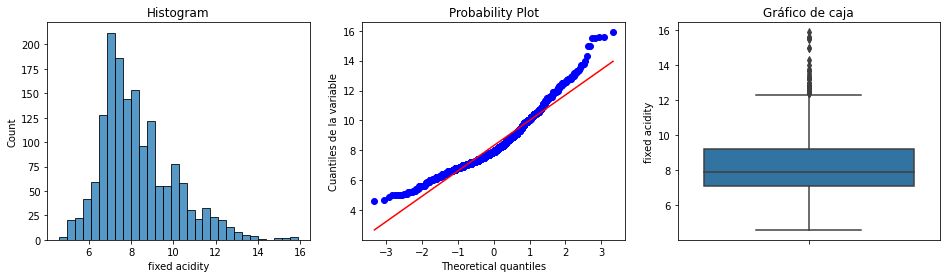

volatile acidity


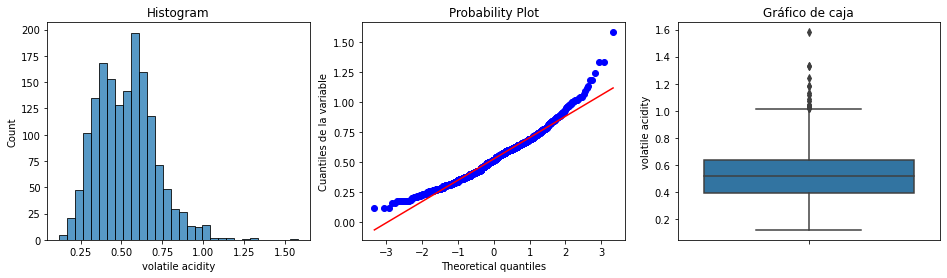

citric acid


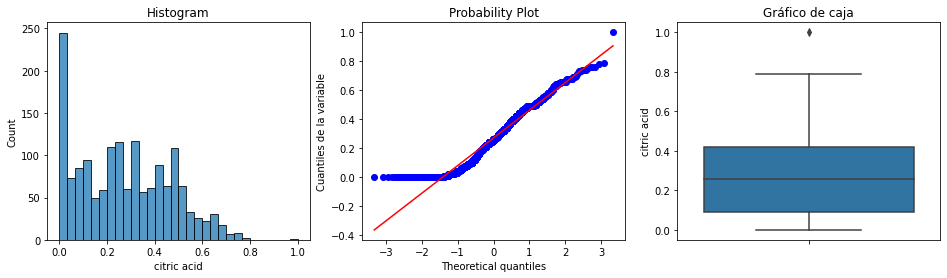

residual sugar


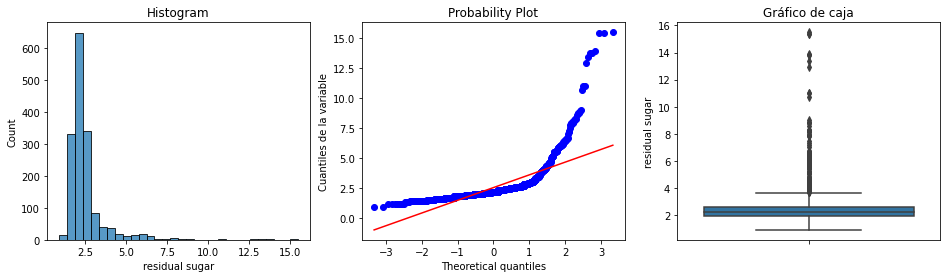

chlorides


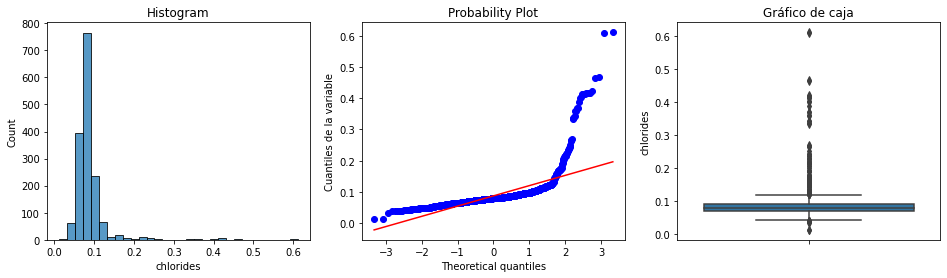

free sulfur dioxide


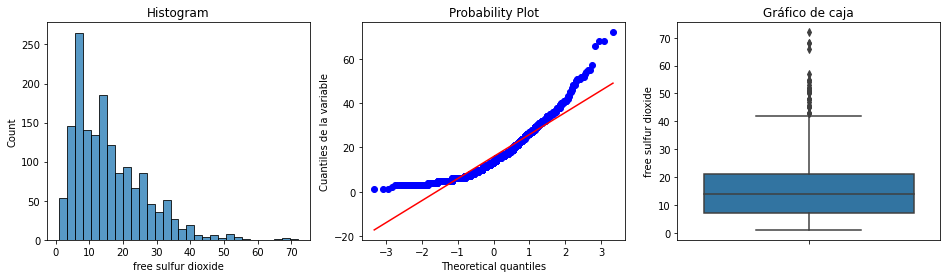

total sulfur dioxide


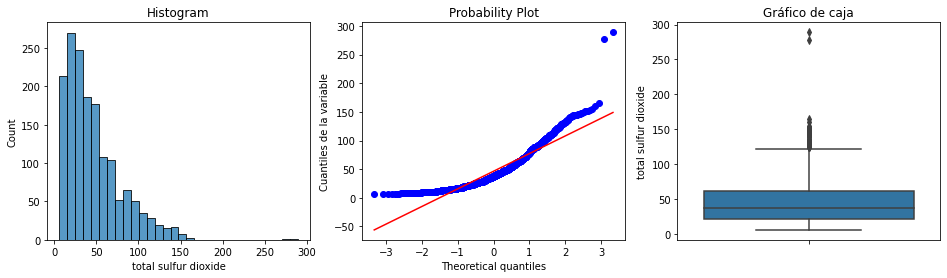

density


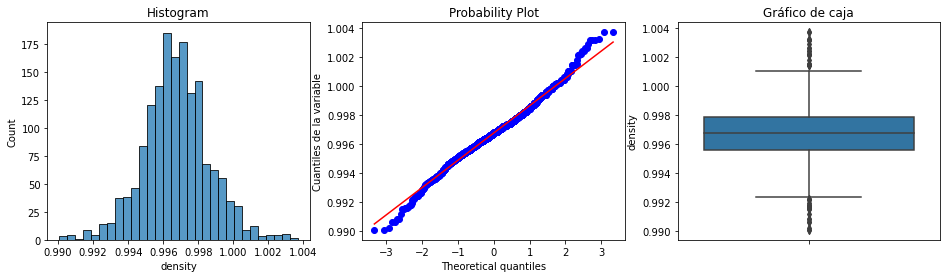

pH


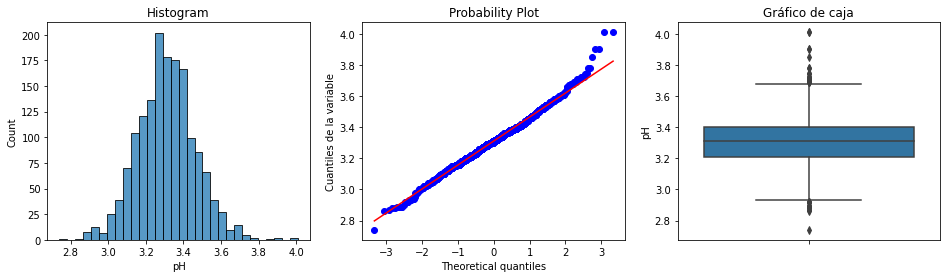

sulphates


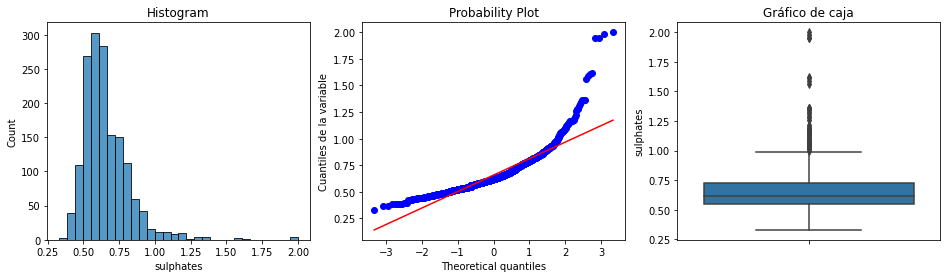

alcohol


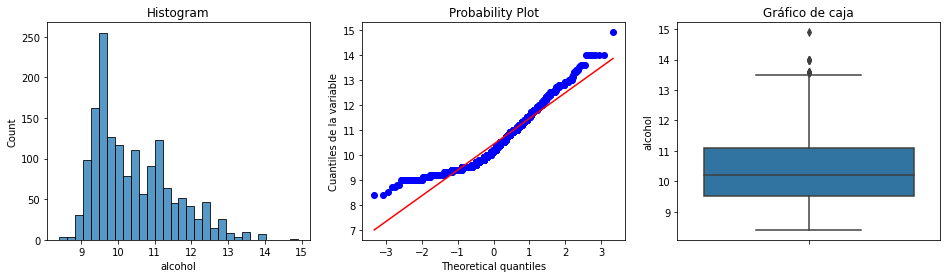

quality


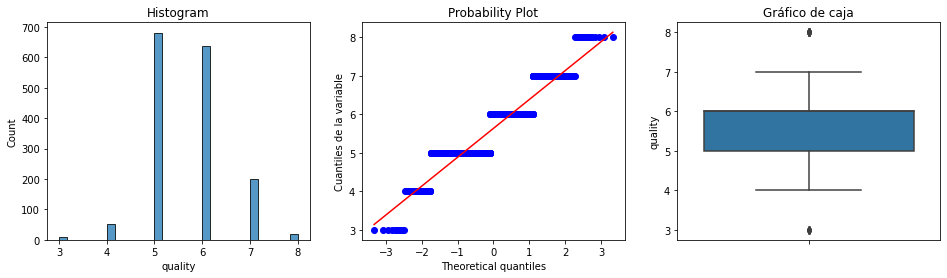

In [9]:
columnas=data.columns.values.tolist()
for x in columnas:
  print(x)
  diagnostic_plots(data,x)

Realizamos el tratamiento de los outliers, así como una transformación para dibujar mejor nuestros datos

In [10]:
#Transformaciones para ver los datos más normales

lt = vt.YeoJohnsonTransformer(variables = ['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',])
lt.fit(data)
df=lt.transform(data)

Como tenemos varios outliers en algunas variables, vamos a optar por realizar un RobustScaling para escalar las variables.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('quality', axis=1),
                                                    data['quality'],
                                                    test_size=0.05,
                                                    random_state=0)

X_train.shape, X_test.shape

((1519, 11), (80, 11))

In [12]:
scaler = RobustScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
datos=pd.DataFrame(X_train_scaled,columns=['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol'])
datos_test=pd.DataFrame(X_test_scaled,columns=['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol'])

In [14]:
X_train=tf.convert_to_tensor(X_train_scaled,np.float64)
y_train=tf.convert_to_tensor(y_train,np.float64)

X_test=tf.convert_to_tensor(X_test_scaled,np.float64)
y_test=tf.convert_to_tensor(y_test,np.float64)

2022-03-14 15:28:39.278181: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Creación y entrenamiento del modelo

In [15]:
class FFNNHyperModel (HyperModel): 

  def build(self, hp): 


    # Optimización de nuestra primera capa de neuronas densa                 
    hp_units=hp.Int("dense_1_units", 
                    min_value=22,
                    max_value=42,
                    step=3,
                    default=30)
     # Optimización de nuestra segunda capa de neuronas densa                 
    hp_units2=hp.Int("dense_2_units", 
                    min_value=100,
                    max_value=200,
                    step=3,
                    default=120) 

    # Optimización de la función de activación para las capas densas
    hp_function=hp.Choice("dense_activation",
                          values=["relu","tanh", "sigmoid"],
                          default="relu")

    #Optimización del ratio de aprendizaje de la función de optimización
    hp_la= hp.Float("learning_rate",
                     min_value=0.01,
                     max_value=0.20,
                     step=0.005,
                     default=0.01)
    
    #Ahora tenemos que crear el modelo aquí dentro para que la función
    #cree la red neuronal y se optimice a la vez
    layers=[keras.layers.Flatten(name="input", input_shape=(11,)),
            
            keras.layers.Dense( 
                name="hidden_1",
                units=hp_units,
                activation=hp_function),
            
            keras.layers.Dense( 
                name="hidden_2",
                units=hp_units2,
                activation=hp_function),
            
            keras.layers.Dense(
                name="hidden_3",
                units=500,
                activation=hp_function
            ),
            
            keras.layers.Dense(
                name="output",
                units=1,
                activation=tf.keras.activations.linear)]

    model= keras.Sequential(layers, name="Regresion_multiple")

    model.compile(
        optimizer= tf.keras.optimizers.SGD(lr=hp_la),
        loss="mae",
        metrics=["mse"])
    
    model.summary()
    return model

In [16]:
MAX_TRIALS= 10
EXECUTION_PER_TRIAL=3 
SEED=98

hypermodel= FFNNHyperModel() 


tuner=RandomSearch(hypermodel, 
    objective="mse", 
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory= "random_search", 
    project_name="Optimizacion_HP")

tuner.search_space_summary()

Model: "Regresion_multiple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 11)                0         
_________________________________________________________________
hidden_1 (Dense)             (None, 30)                360       
_________________________________________________________________
hidden_2 (Dense)             (None, 120)               3720      
_________________________________________________________________
hidden_3 (Dense)             (None, 500)               60500     
_________________________________________________________________
output (Dense)               (None, 1)                 501       
Total params: 65,081
Trainable params: 65,081
Non-trainable params: 0
_________________________________________________________________
Search space summary
Default search space size: 4
dense_1_units (Int)
{'default': 30, 'conditions': [], 'min_v

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
tuner.search(X_train,
             y_train,
             epochs = 100,
             validation_split=0.06)

Trial 10 Complete [00h 00m 55s]
mse: 0.460316797097524

Best mse So Far: 0.16598989566167197
Total elapsed time: 00h 08m 01s


In [18]:
best_model=tuner.get_best_models(num_models=1)

Model: "Regresion_multiple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 11)                0         
_________________________________________________________________
hidden_1 (Dense)             (None, 25)                300       
_________________________________________________________________
hidden_2 (Dense)             (None, 199)               5174      
_________________________________________________________________
hidden_3 (Dense)             (None, 500)               100000    
_________________________________________________________________
output (Dense)               (None, 1)                 501       
Total params: 105,975
Trainable params: 105,975
Non-trainable params: 0
_________________________________________________________________


In [19]:
best= best_model[0]

loss,mse= best.evaluate(X_test,y_test)

print(loss,mse)

3/3 [==============================] - 0s 4ms/step - loss: 0.4318 - mse: 0.4092
0.4318488538265228 0.40923357009887695


In [20]:
def print_regression_line(model,X_print,X,Y):
  plt.rcParams["figure.figsize"]=(14,6)
  plt.rcParams["lines.linewidth"]= 3
  plt.rcParams["axes.labelsize"]= 20
  plt.scatter(X_print, Y, label="Real")
  plt.scatter(X_print, model.predict(X).flatten(), label="Predecido")
  plt.legend(["Real", "Predecido"])
  plt.show()

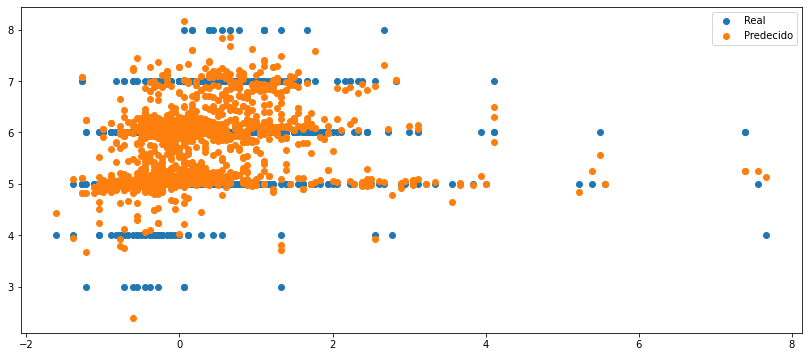

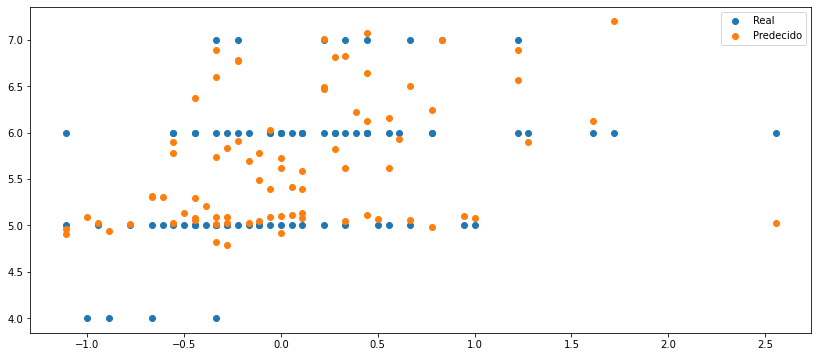

In [21]:
print_regression_line(best,datos["sulphates"],X_train,y_train)
print_regression_line(best,datos_test["sulphates"],X_test,y_test)